Mount the modified dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Same imports as the base model

In [0]:
# imports
import os
from keras.applications import NASNetLarge
from keras import models, layers, optimizers, backend
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

Google collab likes to play roulette with the GPU, so we opt to get "rolling" until we get a Tesla P100 with compute capability 6.0

In [71]:
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices(): 
  if x.device_type == "GPU":
    print("***** GPU Information *****")
    print("Device Name: " , x.name)
    print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB") 
    print("Description: " , x.physical_device_desc)

***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  15.96 GB
Description:  device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Here we experiment with a slightly smaller image size

In [0]:
# Setting Parameters ##################################################################
# image settings
img_height,img_width = 331, 331  # For NASNetLarge

Here is the only change that had to be made in order to allow for Civilian cars to be removed. The classnames and classes variables carry through throughout the notebook

In [0]:
# classes
classnames = ["Background", "BMP2", "Buk-M1-2", "T14", "T90", "ZSU23"]
classes = len(classnames)


A lot of changes to the pathing had to be made in order to make it work with the way the folder was actually laid out in drive

In [0]:
# path settings
path = '/content/drive/My Drive/'
dataset_path = path+'/RuTanks7000_v1/'
weights_path = dataset_path+'trained_models/trained_weights/weights_temp.h5'
model_path = dataset_path+'trained_models/RuTanks7000_v1_'
TensorBoardLogDir = dataset_path+'logs'

Load in the images

In [0]:
nbrTrainImages = 7000  # per class
nbrTestImages = 0  # Value gets accurate after counting (Total Number of test images)
for ImagesClass in os.listdir(dataset_path+'test/'):
    nbrTestImages += len(os.listdir(dataset_path+'test/'+ImagesClass))

In [0]:
# unfreezing the base network up to a specific layer in Level2:
freezeUptoLayer = "normal_add_1_15"   # NASNetLarge

Here we slightly altered the learning rate to attempt to speed up performance

We also experiement with raising the batch size, however collab can barely handle what had already been used, so I opted to just keep that the same after some trial and error

In [0]:
# hyperparameters
learning_rate = 0.0002  # Learning_rate in Level 2 = learning_rate/10
lr_decay = 0.0001
batch = 64
fcLayer1 = 32
dropout = 0.5

epochsL1 = 10
patiencel1 = 1
factorL1 = 0.5

epochsL2 = 10
patiencel2 = 1
factorL2 = 0.5

verbose_train = 1

Data generation

In [78]:
# datagenerators https://keras.io/preprocessing/image/
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    dataset_path+'train',
    target_size=(img_height, img_width),
    batch_size=batch,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_path+'test',
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=True,
    classes=classnames,
    class_mode='categorical')

Found 42000 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


Code for plotting the progress of training across both levels one and two

In [0]:
# function to plot results of model performance
def plot(h,t,e):
    history_dict = h[0]
    loss_values = history_dict['loss']
    validation_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    validation_acc_values = history_dict['val_acc']
    epochs_range = range(1, e + 1)

    # Plotting Training and Validation loss of the corresponding Model
    plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_range, validation_loss_values, 'ro', label='Validation loss')
    plt.title('Training and validation loss of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0, 3.1, step=0.2))
    plt.legend()
    plt.show()

    # Plotting Training and Validation accuracy of the corresponding Model
    plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs_range, validation_acc_values, 'ro', label='Validation accuracy')
    plt.title('Training and validation accuracy of ' + t)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.yticks(np.arange(0.3, 1.1, step=0.1))
    plt.legend()
    plt.show()


Main function for actually running through the two levels

In [0]:
def main():
    start = timer()
    level1()  # Training the classifier only
    level2()  # Training the pretrained model + the trained classifier from level 1
    end = timer()
    print("Time elapsed in minutes: ", ((end - start)/60))

The network was, for the most part, very similar to the one provided. However, it took an very long time to trian, so some modfications were made. Reducing steps per epoch by a factor of 5 actually reduced training time by a factor of nearly 100. 

However, it is possible that it sacrificed a lot of accuracy. It is unfortunately impossible for me to know if running the full 80 hours would result in a more accurate model because collab never stayed running long enough, and would draw way too much electricity on my home setup.

In [0]:
# LEVEL1 - Training of densely connected layers
def level1():
    # Building the model using the pretrained model
    conv_base1 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    print("\n### LEVEL1 ###\npretrained network:")
    conv_base1.summary()
    model = models.Sequential()
    model.add(conv_base1)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(fcLayer1, activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(classes, activation='softmax'))

    # freezing the base network
    print("trainable layers bevor freezing:", int(len(model.trainable_weights)/2)) # weights = weights + bias = 2 pro layer
    conv_base1.trainable = False
    print("trainable layers after freezing:", int(len(model.trainable_weights)/2))
    print("\npretrained network + densely connected classifier")
    model.summary()

    # training the added layers only
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate, decay=lr_decay), metrics=['acc'])

    callbacks_list_L1 = [ModelCheckpoint(filepath=weights_path, save_weights_only=True, monitor='val_acc', verbose=1, save_best_only=True),
                      ReduceLROnPlateau(monitor='val_acc', factor=factorL1, patience=patiencel1, verbose=1),
                      TensorBoard(log_dir=TensorBoardLogDir+'\\level1')]

    print("\n### Level1 Training ... ")
    # training the model
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
        epochs=epochsL1,
        callbacks=callbacks_list_L1,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val1 = [history.history]  # saving all results of the final test
    plot(history_val1, "LEVEL1:", epochsL1)
    print("\n### LEVEL1 Training finished successfully ###")

    print("\nLoading trained weights from " + weights_path + " ...")
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate), metrics=['acc'])
    print("\n### Saving Level1 Model to ", model_path+'l1.h5', " ... ")
    model.save(model_path+'l1.h5')


A similar change was made to level 2 as to level 1. I opted to stick with the same pre trained model, as many other pretrained models simply didn't work at all.

In [0]:
# LEVEL2 - Training pretrained network and trained densely connected layers
def level2():
    # Destroying the current TF graph - https://keras.io/backend/
    backend.clear_session()
    print("\n### LEVEL2 ###")
    conv_base2 = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    model2 = models.Sequential()
    model2.add(conv_base2)
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(layers.Dense(fcLayer1, activation='relu'))
    model2.add(layers.Dropout(dropout))
    model2.add(layers.Dense(classes, activation='softmax'))

    print("\nLoading trained weights from " + weights_path + " ...")
    model2.load_weights(weights_path)

    # unfreezing the base network up to a specific layer:
    if freezeUptoLayer == "":
        conv_base2.trainable = True
        print ("\ntrainable layers: ",int(len(model2.trainable_weights) / 2))
    else:
        print("\ntrainable layers before unfreezing the base network up to " + freezeUptoLayer + ": ",int(len(model2.trainable_weights) / 2))  # weights = weights + bias = 2 pro layer
        conv_base2.trainable = True
        set_trainable = False
        for layer in conv_base2.layers:
            if layer.name == freezeUptoLayer: set_trainable = True
            if set_trainable: layer.trainable = True
            else: layer.trainable = False
        print("trainable layers after the base network unfreezed from layer " + freezeUptoLayer + ": ", int(len(model2.trainable_weights)/2))

    print("\nLEVEL2 Model after unfreezing the base network")
    model2.summary()
    model2.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=learning_rate/10, decay=lr_decay), metrics=['acc'])
    print ("\n### Validating ... ")

    val_loss, val_acc = model2.evaluate_generator(test_generator, steps=nbrTestImages, verbose=0)
    print('Validation Results before training unfreeze layers and trained densely connected layers:\nValidation loss:',val_loss,",",'Validation accuracy:', val_acc, "\n")

    # Jointly training both the unfreeze layers and the added trained densely connected layers
    callbacks_list_L2 = [ModelCheckpoint(filepath=model_path+'l2.h5', save_weights_only=False, monitor='val_acc', verbose=1, save_best_only=True),
                      ReduceLROnPlateau(monitor='val_acc', factor=factorL2, patience=patiencel2, verbose=1),
                      TensorBoard(log_dir=TensorBoardLogDir+'\\level2')]

    print ("\n### Level2 Training ... ")
    history = model2.fit_generator(
        train_generator,
        steps_per_epoch=(nbrTrainImages * classes) // (batch * 5),
        epochs=epochsL2,
        callbacks=callbacks_list_L2,
        validation_data=test_generator,
        validation_steps=nbrTestImages,
        verbose=verbose_train)

    history_val2 = [history.history]  # saving all results of the final test
    plot(history_val2, "LEVEL2:", epochsL2)
    print("\n###LEVEL2 Training finished successfully ###")



### LEVEL1 ###
pretrained network:
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1301 (Activation)    (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_________________________________________________________

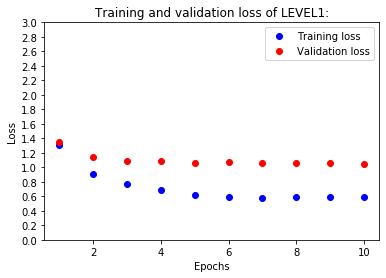

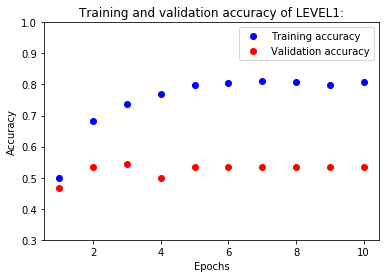


### LEVEL1 Training finished successfully ###

Loading trained weights from /content/drive/My Drive//RuTanks7000_v1/trained_models/trained_weights/weights_temp.h5 ...

### Saving Level1 Model to  /content/drive/My Drive//RuTanks7000_v1/trained_models/RuTanks7000_v1_l1.h5  ... 


### LEVEL2 ###

Loading trained weights from /content/drive/My Drive//RuTanks7000_v1/trained_models/trained_weights/weights_temp.h5 ...

trainable layers before unfreezing the base network up to normal_add_1_15:  510
trainable layers after the base network unfreezed from layer normal_add_1_15:  71

LEVEL2 Model after unfreezing the base network
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
____________________

In [0]:
main()

# *Analysis*
This is mostly equivilant to the original file other than some technical tweaks to get it to run properly

In [0]:
# imports
import os
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns




In [0]:
def a_main():
    analysis()
    plot_images()

In [0]:
# Setting Parameters ##################################################################
model_path = '/content/drive/My Drive/RuTanks7000_v1/trained_models/RuTanks7000_v1_l2.h5'
test_path = '/content/drive/My Drive/RuTanks7000_v1/test'  #  105 Test images

In [0]:
# test data generator
test_datagen = image.ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle=False,
    classes=classnames,
    class_mode='categorical')


In [0]:
# counting test images
nbrTestImages = 0  # Value gets accurate after counting
for ImagesClass in os.listdir(test_path):
    nbrTestImages += len(os.listdir(test_path + ImagesClass))


In [0]:
# saving test images from test generator
test_images = []
for i in range(nbrTestImages):
    test_images.append(test_generator.next()[0][0])

In [0]:
test_images_path = []
true_labels = []
true_labels_class = []

In [0]:
test_images_Background = os.listdir(test_path + 'Background')
for imagefile in test_images_Background:
    test_images_path.append(test_path + 'Background/' + imagefile)
    true_labels.append(0)
    true_labels_class.append('Background')

In [0]:
test_images_BMP2 = os.listdir(test_path + 'BMP2')
for imagefile in test_images_BMP2:
    test_images_path.append(test_path + 'BMP2/' + imagefile)
    true_labels.append(1)
    true_labels_class.append('BMP2')

In [0]:
test_images_Buk = os.listdir(test_path + 'Buk-M1-2')
for imagefile in test_images_Buk:
    test_images_path.append(test_path + 'Buk-M1-2/' + imagefile)
    true_labels.append(2)
    true_labels_class.append('Buk-M1-2')

In [0]:
test_images_T14 = os.listdir(test_path + 'T14')
for imagefile in test_images_T14:
    test_images_path.append(test_path + 'T14/' + imagefile)
    true_labels.append(4)
    true_labels_class.append('T14')

In [0]:
test_images_T90 = os.listdir(test_path + 'T90')
for imagefile in test_images_T90:
    test_images_path.append(test_path + 'T90/' + imagefile)
    true_labels.append(5)
    true_labels_class.append('T90')

In [0]:
test_images_ZSU23 = os.listdir(test_path + 'ZSU23')
for imagefile in test_images_ZSU23:
    test_images_path.append(test_path + 'ZSU23/' + imagefile)
    true_labels.append(6)
    true_labels_class.append('ZSU23')

In [0]:
# Returns the compiled model identical to the previously saved one
print("Loading the trained model from " + model_path + " ...\n")
model = models.load_model(model_path)
print("\nTrained model " + model_path + ":")
model.summary()

In [0]:
# predicting labels
pred = model.predict_generator(test_generator, nbrTestImages)
print("Dataset at", test_path, "has", pred.shape[0], "images with", pred.shape[1], "class predictions each")

In [0]:

def analysis():
    # testing the model
    print("\n### Testing the loaded model ... ")
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=nbrTestImages, verbose=1)
    print('Test Results of the trained Model:\nTest loss:', test_loss, ",", 'test accuracy:', test_acc)

    # Confusion Matrix and Classification Report
    pred_argmax = np.argmax(pred, axis=1)
    print('\nConfusion Matrix')
    print(confusion_matrix(test_generator.classes, pred_argmax))
    print('\nClassification Report')
    print(classification_report(test_generator.classes, pred_argmax, target_names=classnames))

    # t-SNE Visualization: t-Distributed Stochastic Neighbor Embedding (t-SNE) for visualizing high-dimensional data.
    img_tensors = []
    for i in range(len(test_images)):
        pred_img = image.load_img(test_images_path[i], target_size=(331, 331))
        img_tensor = image.img_to_array(pred_img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.
        img_tensors.append(img_tensor)

    # Last conv layer
    layer = model.get_layer('dense_1')
    layer_output = layer.output
    activation_model = models.Model(input=model.input, outputs=[layer_output])

    img_tensors = np.asarray(img_tensors)
    img_tensors_array = np.concatenate((img_tensors))
    print("img_tensors_array.shape=", img_tensors_array.shape)

    activations = activation_model.predict(img_tensors_array)
    print("activations.shape=", activations.shape)

    # calculating tsne #https://www.datacamp.com/community/tutorials/introduction-t-sne
    tsne = TSNE(random_state=42).fit_transform(activations)

    # Visualization of the feature vectors produce by the convnet
    num_classes = len(classnames)
    palette = np.array(sns.color_palette("husl", num_classes))
    label_array = np.asarray(true_labels)

    # create a scatter plot.
    fig = plt.figure(figsize=(12, 12))
    fig.patch.set_facecolor('black')
    plt.style.use('dark_background')
    plt.scatter(tsne[:, 0], tsne[:, 1], lw=0, s=90, c=palette[label_array])
    plt.axis('tight')

    txts = []
    for j in range(num_classes):
        # Position of each label at median of data points.
        xtext, ytext = np.median(tsne[label_array == j, :], axis=0)
        txt = plt.text(xtext, ytext, classnames[j], fontsize=28, color = 'w')
        txts.append(txt)
    plt.show()


In [0]:
def plot_images():
    # plotting test images with class predictions as title
    print("\nClass Predictions of test images from", test_path)
    for k in range(len(test_images)):
        predictions = []
        for l in range(len(classnames)):
            predictions.append((np.round(pred[k][l] * 100, 2), classnames[l]))
        predictions.sort(reverse=True)
        print("Image", k + 1, ":", predictions)

        plt.figure(figsize=(8, 8))  # width, height in inches.
        plt.style.use('dark_background')
        plt.suptitle("Class prediction of a " + true_labels_class[k] + " image" + "\n(Test image " + str(k + 1) + ")", fontsize=18)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        legend_string = "Prediction: " + \
                        "\n%.2f" % predictions[0][0] + "% " + predictions[0][1] + \
                        "\n%.2f" % predictions[1][0] + "% " + predictions[1][1] + \
                        "\n%.2f" % predictions[2][0] + "% " + predictions[2][1] + \
                        "\n%.2f" % predictions[3][0] + "% " + predictions[3][1] + \
                        "\n%.2f" % predictions[4][0] + "% " + predictions[4][1] + \
                        "\n%.2f" % predictions[5][0] + "% " + predictions[5][1] + \
                        "\n%.2f" % predictions[6][0] + "% " + predictions[6][1]
        plt.text(img_width + 10, 125, legend_string, fontsize=16)
        plt.imshow(test_images[k])
        plt.show()

In [0]:
a_main()